# TALLER 2

MINE-4101: Applied Data Science  
Universidad de los Andes  
  
**Última Actualización**: Octubre, 2022  
  
**Datos**: Información de condiciones metereológicas de la ciudad.

**Fuente**: Entidad regional/nacional de información de clima y metereología.

**Objetivo:** Implementar un modelo de regresión para incentivar la movilidad sostenible mediante patineta.

**Diccionario de datos:**

| Campo | Descripción |
| :- | :- |
| Instant | Record Index |
| Date | Date (Format: YYYY-MM-DD) |
| Season | Season of the year |
| Holiday | Is it holiday? |
| Weather | Description of the weather situation |
| Temp | Temperature in Celsius |
| Feel_Temp | Feeling temperature in Celsius |
| Hum | Normalized humidity |
| Wind | Wind speed in m/s |
| Casual | Count of casual users |
| Registered | Count of registered users |
| cnt | Count of total rental bikes including both casual and registered |

**Autor:** Fabián Camilo Castellanos Pinto

*Aspirante a Magister en Ingeniería de Información*.

## Prerequisitos

In [1]:
!pip install --upgrade pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import pandas as pd

import calendar
import math
import matplotlib.pyplot as plt
import pylev
import re
import seaborn as sns

from datetime import datetime

from pandas_profiling import ProfileReport

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

##1. Análisis exploratorio de datos



Cargo la información en un dataframe de pandas

In [5]:
datos = pd.read_csv('Data_Taller_2.csv', sep = ';')

In [6]:
columnas = ["instant", "Date", "Season", "Holiday", "Weather", "Temp", "Feel_Temp", "Hum", "Wind", "Casual", "Registered", "cnt"]

Verifico la cantidad de información

In [7]:
print("El dataset cuenta con {} registro(s)".format(datos.shape[0]))

El dataset cuenta con 731 registro(s)


Las columnas de información

In [8]:
datos.dtypes

instant        int64
Date          object
Season        object
Holiday       object
Weather       object
Temp          object
Feel_Temp     object
Hum           object
Wind          object
Casual         int64
Registered     int64
cnt            int64
dtype: object

Una previsualización de los datos

In [9]:
datos.head()

,instant,Date,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt
0,1,1/01/2020,Springer,No,Mist + Cloudy,"8,175849","9,090375","0,805833","10,749882",331,654,985
1,2,2/01/2020,Springer,No,Mist + Cloudy,"9,083466","8,625733","0,696087","-16,652113",131,670,801
2,3,3/01/2020,Springer,No,Few clouds,"1,229108","0,902035","0,437273","16,636703",120,1229,1349
3,4,4/01/2020,Springer,No,Few clouds,"1,4","1,969734","0,590435","10,739832",108,1454,1562
4,5,5/01/2020,Springer,No,Partly cloudy,"2,666979","2,77569","0,436957","12,5223",82,1518,1600


Perfilamiento de los datos

In [10]:
profile_hist = ProfileReport(datos)

In [11]:
profile_hist.to_notebook_iframe()

Output hidden; open in https://colab.research.google.com to view.

Información complementaria de los datos

In [12]:
tipos_numerico = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_df = datos.select_dtypes(include=tipos_numerico)
columnas_numericas = num_df.columns.to_list()

for columna in columnas:
  try:
    indice = columnas_numericas.index(columna)
  except:
    indice = -1

  if(indice >= 0):  
      max = datos[columna].max()
      min = datos[columna].min()
  else:
    max = "No Aplica"
    min = "No Aplica"

  nulos = datos[columna].loc[datos[columna].isnull()].shape[0]
  print("Columna: '{}', Tipo de dato: {}, Valor mínimo: {}, Valor máximo: {}, Total valores nulos: {}".format(columna, datos.dtypes[columna], min, max, nulos))

Columna: 'instant', Tipo de dato: int64, Valor mínimo: 1, Valor máximo: 731, Total valores nulos: 0
Columna: 'Date', Tipo de dato: object, Valor mínimo: No Aplica, Valor máximo: No Aplica, Total valores nulos: 0
Columna: 'Season', Tipo de dato: object, Valor mínimo: No Aplica, Valor máximo: No Aplica, Total valores nulos: 0
Columna: 'Holiday', Tipo de dato: object, Valor mínimo: No Aplica, Valor máximo: No Aplica, Total valores nulos: 0
Columna: 'Weather', Tipo de dato: object, Valor mínimo: No Aplica, Valor máximo: No Aplica, Total valores nulos: 0
Columna: 'Temp', Tipo de dato: object, Valor mínimo: No Aplica, Valor máximo: No Aplica, Total valores nulos: 4
Columna: 'Feel_Temp', Tipo de dato: object, Valor mínimo: No Aplica, Valor máximo: No Aplica, Total valores nulos: 0
Columna: 'Hum', Tipo de dato: object, Valor mínimo: No Aplica, Valor máximo: No Aplica, Total valores nulos: 0
Columna: 'Wind', Tipo de dato: object, Valor mínimo: No Aplica, Valor máximo: No Aplica, Total valores n

Visualización de la información de la columna **instant**

In [13]:
datos['instant'].describe(percentiles = [.25, .5, .75, .95, .99])

count    731.000000
mean     366.000000
std      211.165812
min        1.000000
25%      183.500000
50%      366.000000
75%      548.500000
95%      694.500000
99%      723.700000
max      731.000000
Name: instant, dtype: float64

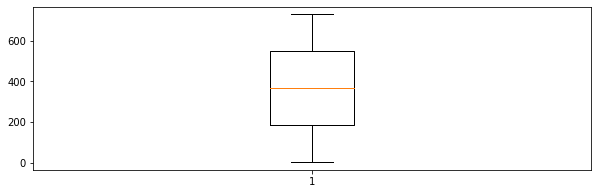

In [14]:
#sns.set(rc={'figure.figsize':(30, 12)}) 
plt.figure(figsize = (10, 3))
plt.boxplot(datos['instant'])
plt.show()

Visualización de la información de la columna **Date**

In [15]:
datos['instant'].value_counts()

1      1
481    1
483    1
484    1
485    1
      ..
246    1
247    1
248    1
249    1
731    1
Name: instant, Length: 731, dtype: int64

TypeError: ignored

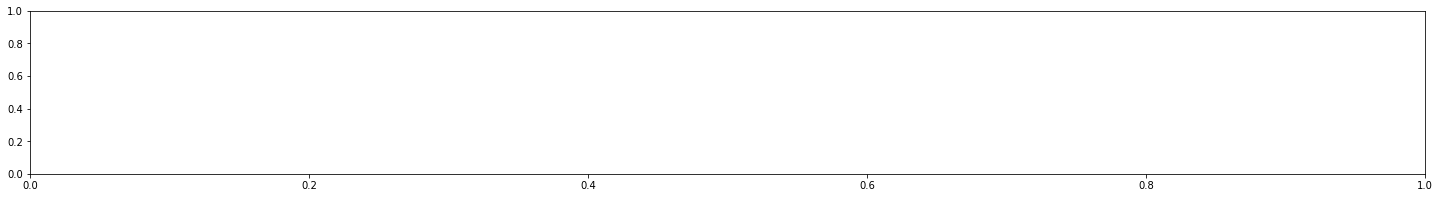

In [26]:
#sns.set(rc={'figure.figsize':(30, 12)}) 
plt.figure(figsize = (10, 3))
plt.boxplot(datos["Date"])
plt.show()

La visualización de la fecha no es apropiada, requiere revisión

Visualización de la información de la columna **Season**

In [17]:
datos['Season'].value_counts()

Fall        188
Summer      184
Springer    181
Winter      178
Name: Season, dtype: int64

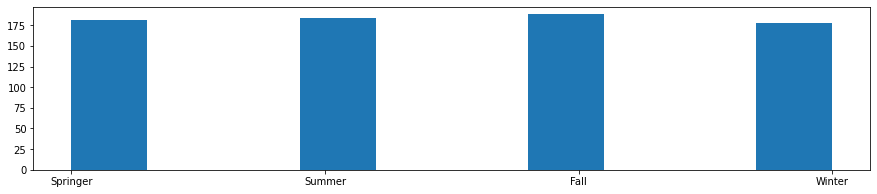

In [18]:
#sns.set(rc={'figure.figsize':(30, 12)}) 
plt.figure(figsize = (15, 3))
plt.hist(data=datos, x="Season")
plt.show()

Visualización de la información de la columna **Holiday**

In [19]:
datos['Holiday'].value_counts()

No     710
Yes     21
Name: Holiday, dtype: int64

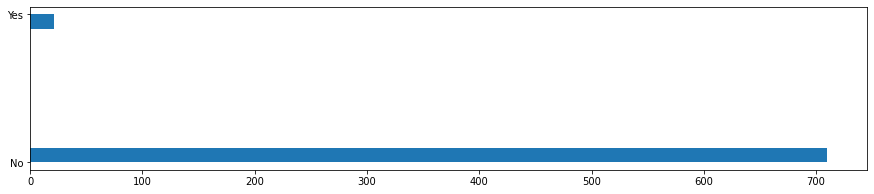

In [20]:
#sns.set(rc={'figure.figsize':(10, 12)}) 
plt.figure(figsize = (15, 3))
plt.hist(data=datos, x="Holiday", orientation="horizontal")
plt.show()

Visualización de la información de la columna **Weather**

In [21]:
datos['Weather'].value_counts()

 Partly    cloudy                128
Few clouds                       118
Clear                            111
 Partly cloudy                   106
Mist + Broken clouds              69
Mist + Cloudy                     66
Mist + Few clouds                 58
Mist                              54
Light Rain + Scattered clouds      8
Rain + Thunderstorm                7
Snow                               6
Name: Weather, dtype: int64

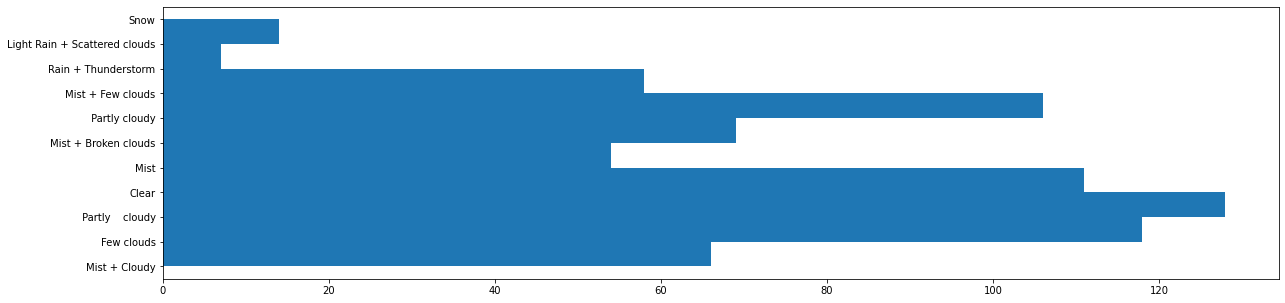

In [22]:
#sns.set(rc={'figure.figsize':(30, 12)}) 
plt.figure(figsize = (20, 5))
plt.hist(data=datos, x="Weather", orientation="horizontal")
plt.show()

Visualización de la información de la columna **Temp**

In [23]:
datos['Temp'].value_counts()

21,845       5
23,96        4
12,5625      4
14,755849    4
24,743349    4
            ..
22,284356    1
21,793911    1
23,450849    1
22,236651    1
2,144151     1
Name: Temp, Length: 496, dtype: int64

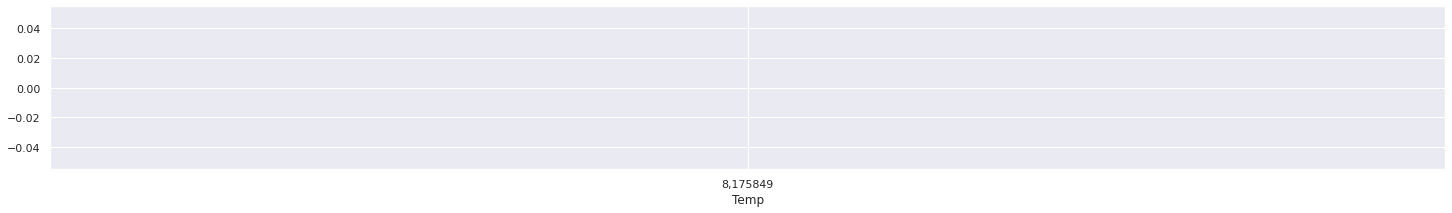

In [40]:
sns.set(rc={'figure.figsize':(30, 12)}) 
plt.figure(figsize = (25, 3))
#colors = np.random.rand(50)
#sns.boxplot(datos['Temp'])
sns.scatterplot(data=datos, x="Temp")
plt.show()

La información no está siendo visualizada como número por las comas presentes en los datos.

Visualización de la información de la columna **Feel_Temp**

In [41]:
datos['Feel_Temp'].value_counts()

22,770336    4
9,654187     3
21,939376    3
18,882825    2
13,926675    2
            ..
19,210462    1
20,633763    1
20,30011     1
21,4643      1
2,503889     1
Name: Feel_Temp, Length: 690, dtype: int64

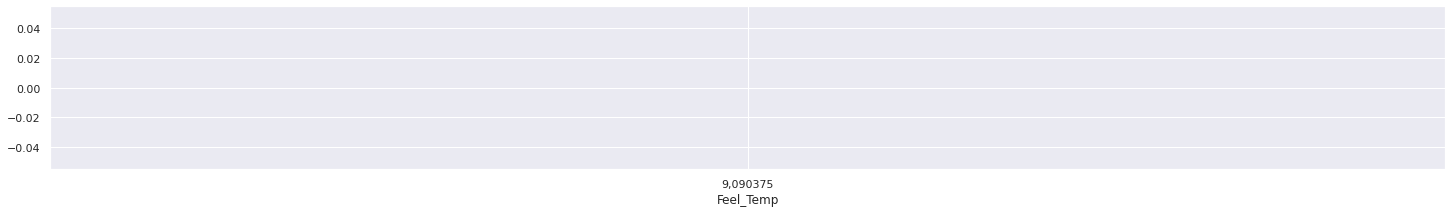

In [42]:
sns.set(rc={'figure.figsize':(30, 12)}) 
plt.figure(figsize = (25, 3))
sns.scatterplot(data=datos, x="Feel_Temp")
plt.show()

La información no está siendo visualizada como número por las comas presentes en los datos.

Visualización de la información de la columna **Hum**

In [43]:
datos['Hum'].value_counts()

0,613333    4
0,74125     3
0,538333    3
0,5425      3
0,697083    3
           ..
0,895217    1
0,712174    1
0,68        1
0,486667    1
0,5775      1
Name: Hum, Length: 596, dtype: int64

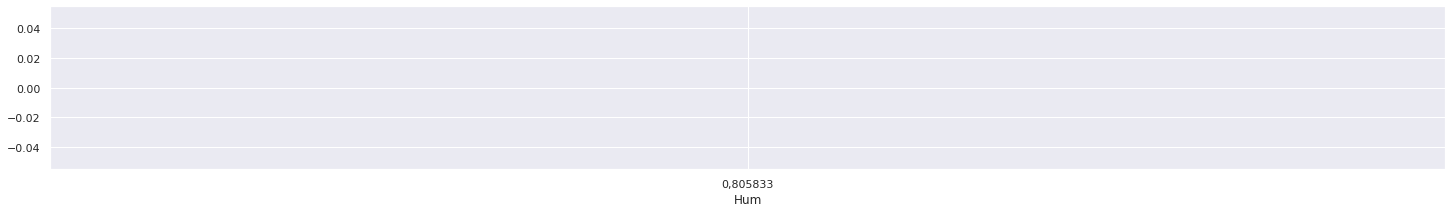

In [44]:
sns.set(rc={'figure.figsize':(30, 12)}) 
plt.figure(figsize = (25, 3))
sns.scatterplot(data=datos, x="Hum")
plt.show()

La información no está siendo visualizada como número por las comas presentes en los datos.

Visualización de la información de la columna **Wind**

In [45]:
datos['Wind'].value_counts()

9,041918     3
15,333486    3
9,166739     3
7,4169       3
7,959064     3
            ..
13,833289    1
14,250632    1
23,044181    1
6,5003936    1
10,374682    1
Name: Wind, Length: 650, dtype: int64

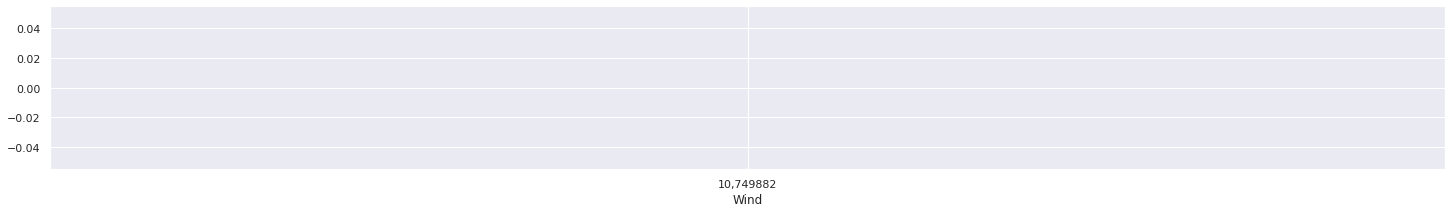

In [46]:
sns.set(rc={'figure.figsize':(30, 12)}) 
plt.figure(figsize = (25, 3))
sns.scatterplot(data=datos, x="Wind")
plt.show()

Visualización de la información de la columna **Casual**

In [47]:
datos['Casual'].describe(percentiles = [.25, .5, .75, .95, .99])

count     731.000000
mean      848.176471
std       686.622488
min         2.000000
25%       315.500000
50%       713.000000
75%      1096.000000
95%      2355.000000
99%      2930.600000
max      3410.000000
Name: Casual, dtype: float64

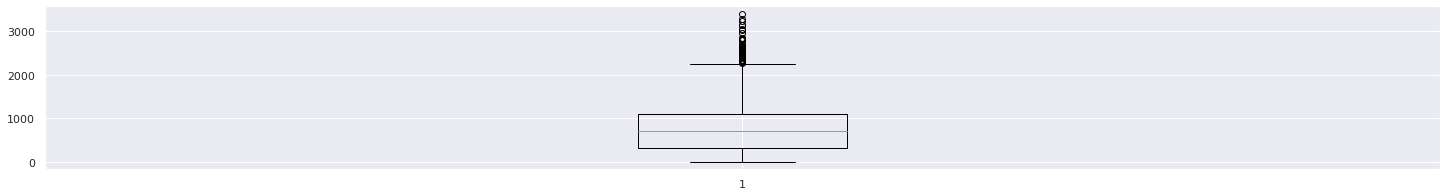

In [48]:
sns.set(rc={'figure.figsize':(30, 12)}) 
plt.figure(figsize = (25, 3))
plt.boxplot(datos['Casual'])
plt.show()

Visualización de la información de la columna **Registered**

In [49]:
datos['Registered'].describe(percentiles = [.25, .5, .75, .95, .99])

count     731.000000
mean     3656.172367
std      1560.256377
min        20.000000
25%      2497.000000
50%      3662.000000
75%      4776.500000
95%      6280.500000
99%      6787.300000
max      6946.000000
Name: Registered, dtype: float64

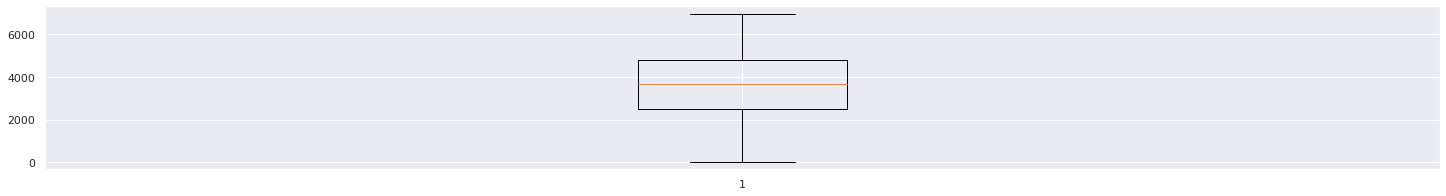

In [50]:
sns.set(rc={'figure.figsize':(30, 12)}) 
plt.figure(figsize = (25, 3))
plt.boxplot(datos['Registered'])
plt.show()

Visualización de la información de la columna **cnt**

In [51]:
datos['cnt'].describe(percentiles = [.25, .5, .75, .95, .99])

count     731.000000
mean     4504.348837
std      1937.211452
min        22.000000
25%      3152.000000
50%      4548.000000
75%      5956.000000
95%      7576.000000
99%      8163.700000
max      8714.000000
Name: cnt, dtype: float64

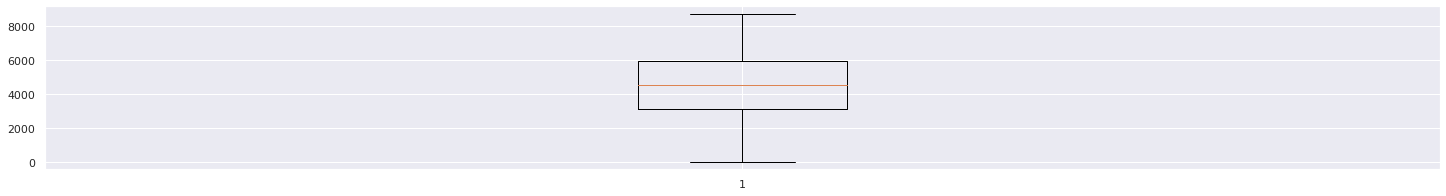

In [52]:
sns.set(rc={'figure.figsize':(30, 12)}) 
plt.figure(figsize = (25, 3))
#sns.boxplot(datos['cnt'])
plt.boxplot(datos['cnt'])
plt.show()

Visualización gráfica de dispersión entre los datos

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


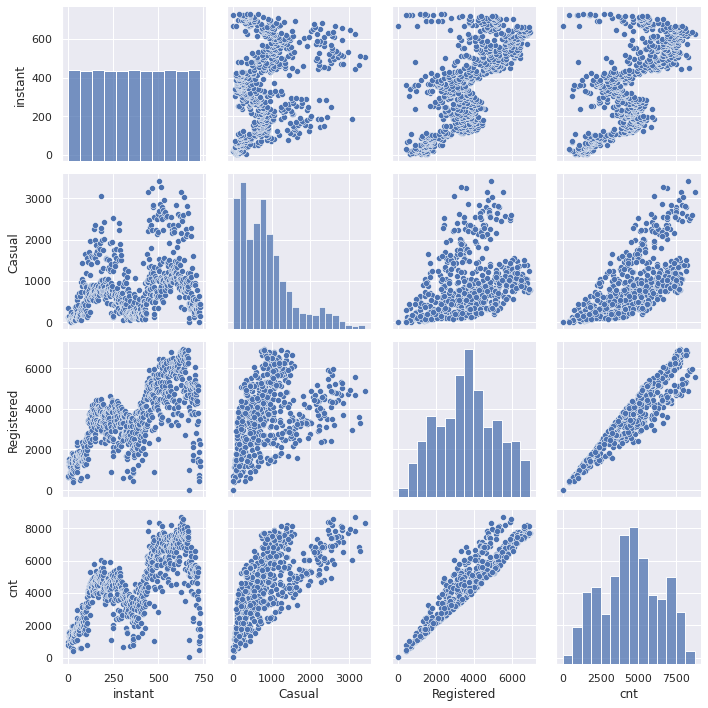

In [53]:
#sns.set(rc={'figure.figsize':(30, 12)}) 
sns.pairplot(datos[columnas], size=2.5)
plt.tight_layout()
plt.show()

##2. Limpieza y preparación de datos

Arreglo para los datos numéricos

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


<Figure size 1440x360 with 0 Axes>

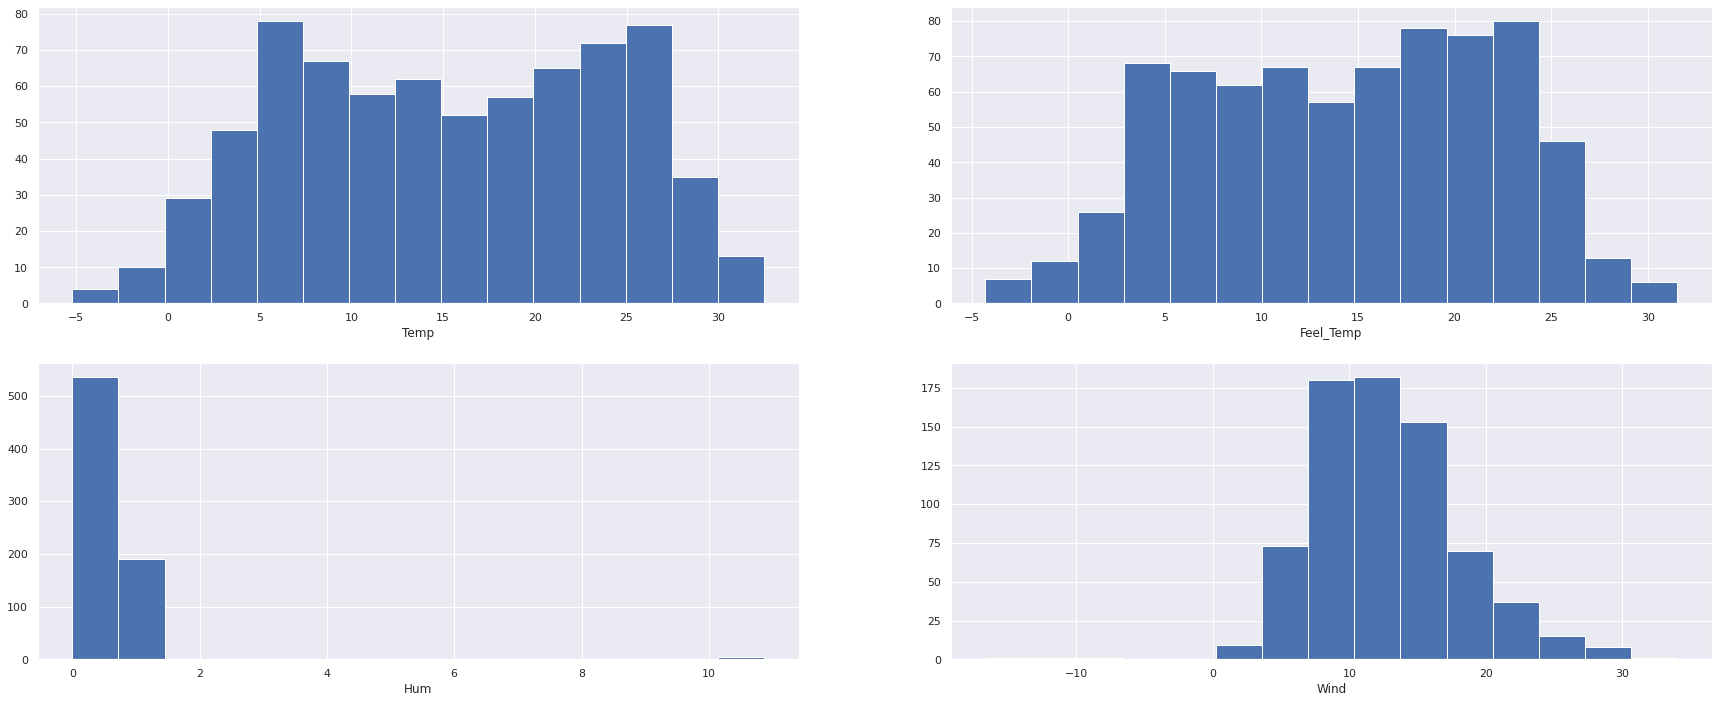

In [54]:
def ajusta_numero(val):
  return float(str(val).replace(",", "."))

columnas_numericas_aj = ["Temp", "Feel_Temp", "Hum", "Wind"]
sub_df = datos[columnas_numericas_aj]

k = 0
#sns.set(rc={'figure.figsize':(30,12)}) 
plt.figure(figsize = (20, 5))
fix, axes = plt.subplots(2, 2)
for columna in columnas_numericas_aj:
  plt.subplot(2, 2 , k + 1)
  sub_df[columna] = sub_df[columna].apply(ajusta_numero)
  datos[columna] = datos[columna].apply(ajusta_numero)
  plt.hist(sub_df[sub_df.columns[k]], bins=15)
  plt.xlabel(sub_df.columns[k])
  k = k + 1

Arreglo de los valores de fechas

In [55]:
#datos = pd.read_csv('Data_Taller_2.csv', sep = ';')
def ajusta_fecha(x):
  try:    
    x = datetime.strptime(x, "%d/%m/%Y").date()
    return x
  except ValueError:
    match_str = re.search(r'\d{2}/\d{2}/\d{4}', x)
    anio = str(match_str.group()[-4:])
    print(anio)
    if(calendar.isleap(int(anio)) == False):
      return "28/02/" + anio
    else:
      return x

datos["Date"] = datos["Date"].apply(ajusta_fecha)
datos['Date'] = datos['Date'].astype('datetime64')
datos["Date"].value_counts()

2021


2021-02-28    2
2020-01-01    1
2021-04-26    1
2021-04-28    1
2021-04-29    1
             ..
2020-09-03    1
2020-09-04    1
2020-09-05    1
2020-09-06    1
2021-12-31    1
Name: Date, Length: 730, dtype: int64

In [56]:
datos.dtypes

instant                int64
Date          datetime64[ns]
Season                object
Holiday               object
Weather               object
Temp                 float64
Feel_Temp            float64
Hum                  float64
Wind                 float64
Casual                 int64
Registered             int64
cnt                    int64
dtype: object

<Figure size 2160x864 with 0 Axes>

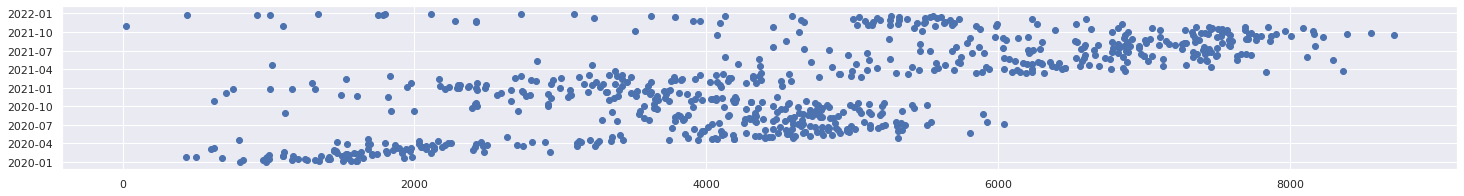

In [57]:
#sns.set(rc={'figure.figsize':(30, 12)}) 
plt.tight_layout()
plt.figure(figsize = (25, 3))
plt.scatter(datos["cnt"], datos["Date"])
plt.show()

La información de la columna **Temp** tiene valores nulos que requieren imputación, usaré la media como criterio de asignación

In [58]:
datos['Temp'].fillna(datos['Temp'].mean(), inplace=True)

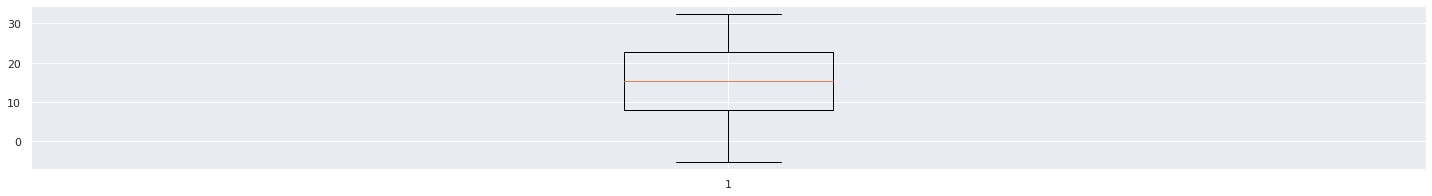

In [59]:
#sns.set(rc={'figure.figsize':(20, 12)}) 
plt.figure(figsize = (25, 3))
plt.boxplot(datos['Temp'])
plt.show()

Verifico que no tenga datos nulos

In [60]:
datos.loc[datos['Temp'].isnull()]

,instant,Date,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt


Recorro nuevamente en todas las variables (columnas) del modelo

In [61]:
tipos_numerico = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_df = datos.select_dtypes(include=tipos_numerico)
columnas_numericas = num_df.columns.to_list()

for columna in columnas:
  try:
    indice = columnas_numericas.index(columna)
  except:
    indice = -1

  if(indice >= 0):  
      max = datos[columna].max()
      min = datos[columna].min()
  else:
    max = "No Aplica"
    min = "No Aplica"

  nulos = datos[columna].loc[datos[columna].isnull()].shape[0]
  print("Columna: '{}', Tipo de dato: {}, Valor mínimo: {}, Valor máximo: {}, Total valores nulos: {}".format(columna, datos.dtypes[columna], min, max, nulos))

Columna: 'instant', Tipo de dato: int64, Valor mínimo: 1, Valor máximo: 731, Total valores nulos: 0
Columna: 'Date', Tipo de dato: datetime64[ns], Valor mínimo: No Aplica, Valor máximo: No Aplica, Total valores nulos: 0
Columna: 'Season', Tipo de dato: object, Valor mínimo: No Aplica, Valor máximo: No Aplica, Total valores nulos: 0
Columna: 'Holiday', Tipo de dato: object, Valor mínimo: No Aplica, Valor máximo: No Aplica, Total valores nulos: 0
Columna: 'Weather', Tipo de dato: object, Valor mínimo: No Aplica, Valor máximo: No Aplica, Total valores nulos: 0
Columna: 'Temp', Tipo de dato: float64, Valor mínimo: -5.2208712, Valor máximo: 32.498349, Total valores nulos: 0
Columna: 'Feel_Temp', Tipo de dato: float64, Valor mínimo: -4.2837288, Valor máximo: 31.522112, Total valores nulos: 0
Columna: 'Hum', Tipo de dato: float64, Valor mínimo: 0.0, Valor máximo: 10.867083, Total valores nulos: 0
Columna: 'Wind', Tipo de dato: float64, Valor mínimo: -16.652113, Valor máximo: 34.000021, Total 

Ajusto los valores de clima

In [62]:
#historico_limpio_df = datos.replace({ 'Weather': {' Partly    cloudy': 'Partly Cloudy', } })
valores_clima = ["Partly Cloudy","Few Clouds","Mist + Broken Clouds","Clear","Mist + Broken clouds", "Mist + Cloudy", "Mist + Few clouds", "Mist", 
                 "Light Rain + Scattered clouds", "Rain + Thunderstorm", "Snow"]

def arregla_clima(d):
  distance = 10
  index = -1
  res = d
  for n in valores_clima:
    try:
      new_distance = pylev.levenshtein(n, d)
      if(new_distance < distance):
        distance = new_distance
        index = valores_clima.index(n)
    except:
      pass

  if(index > -1):
    res = valores_clima[index]

  return res
  
#datos["neighbourhood group"] = 
datos["Weather"] = datos["Weather"].apply(arregla_clima)

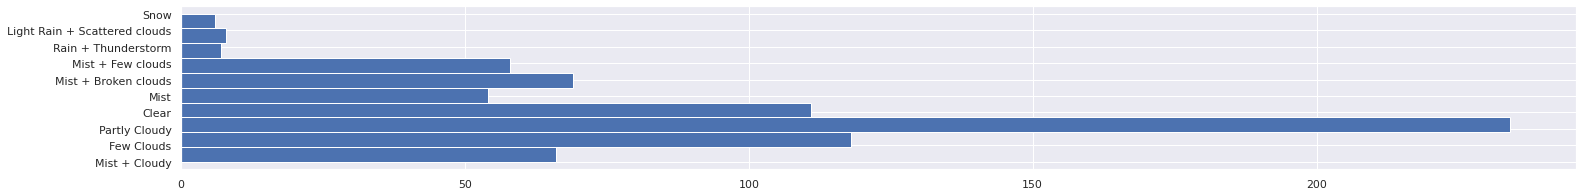

In [63]:
#sns.set(rc={'figure.figsize':(30, 12)}) 
plt.figure(figsize = (25, 3))
plt.hist(data=datos, x="Weather", orientation="horizontal")
plt.show()

Creando nuevas variables

Variable ***Grupo de Clima***

In [64]:
grupo_clima = ["Mist", "Cloudy", "Rain"]
def arregla_grupo_clima(d):
  distance = 10
  index = -1
  res = d
  for n in grupo_clima:
    try:
      new_distance = pylev.levenshtein(n, d)
      if(new_distance < distance):
        distance = new_distance
        index = grupo_clima.index(n)
    except:
      pass

  if(index > -1):
    res = grupo_clima[index]
  else:
    res = "Other"

  return res

datos["Weather Group"] = datos["Weather"].apply(arregla_grupo_clima)
datos["Weather Group"].value_counts()

Cloudy    529
Other     142
Mist       60
Name: Weather Group, dtype: int64

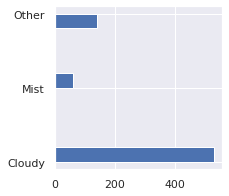

In [65]:
#sns.set(rc={'figure.figsize':(30, 12)}) 
plt.figure(figsize = (3, 3))
plt.hist(data=datos, x="Weather Group", orientation="horizontal")
plt.show()

Variable ***Día de la semana***

In [66]:
def calcula_dia(x):
  return x.weekday() + 1

datos["WeekDay"] = datos["Date"].apply(calcula_dia)

##3. Análisis de datos

3.1. Variables cuantitativas

Reviso a continuación las 8 variables cuantitativas del modelo:

*   Temp
*   Feel_Temp
*   Hum
*   Wind
*   Casual
*   Registered
*   WeekDay
*   cnt

In [67]:
columnas_numericas = ["Temp", "Feel_Temp", "Hum", "Wind", "Casual", "Registered", "WeekDay", "cnt"]
sub_df = datos[columnas_numericas]

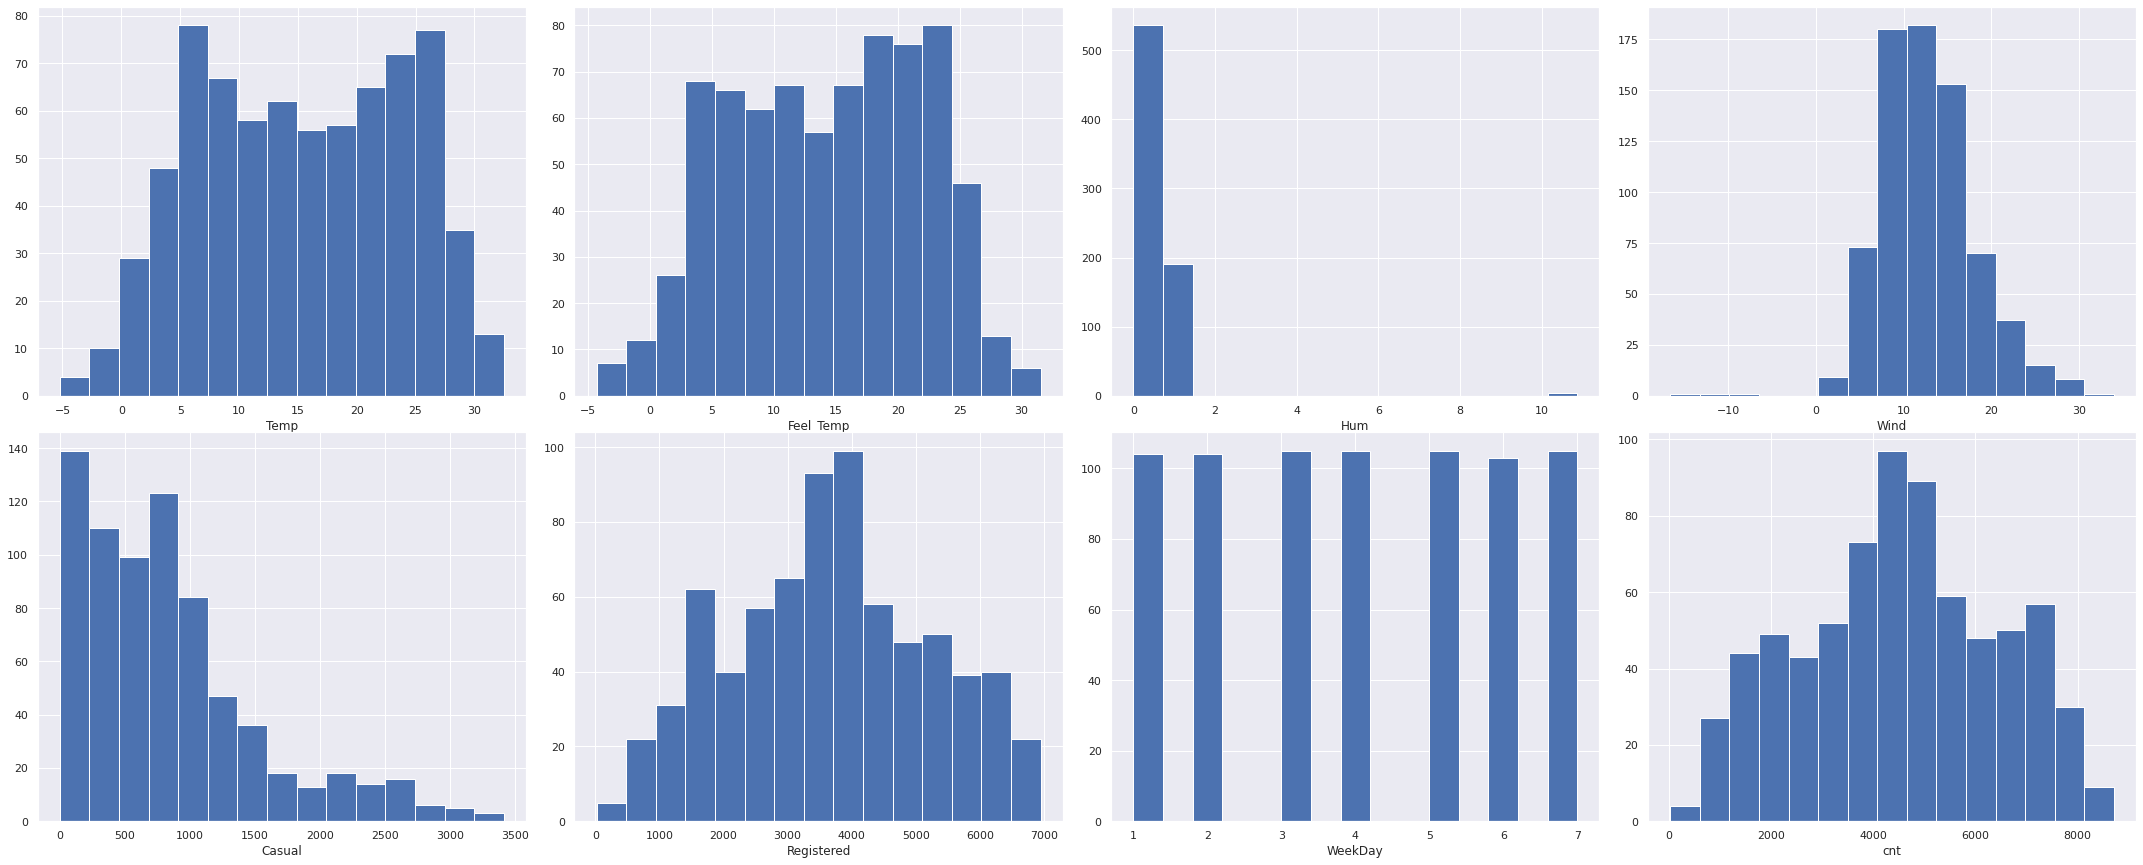

In [68]:
#sns.set(rc={'figure.figsize':(30,12)}) 
fix, axes = plt.subplots(2, 4)
#plt.figure(figsize = (3, 3))
plt.tight_layout()
for k in range(0, len(columnas_numericas)):
  plt.subplot(2, 4 , k + 1)
  plt.hist(sub_df[sub_df.columns[k]], bins=15)
  plt.xlabel(sub_df.columns[k])
plt.show()

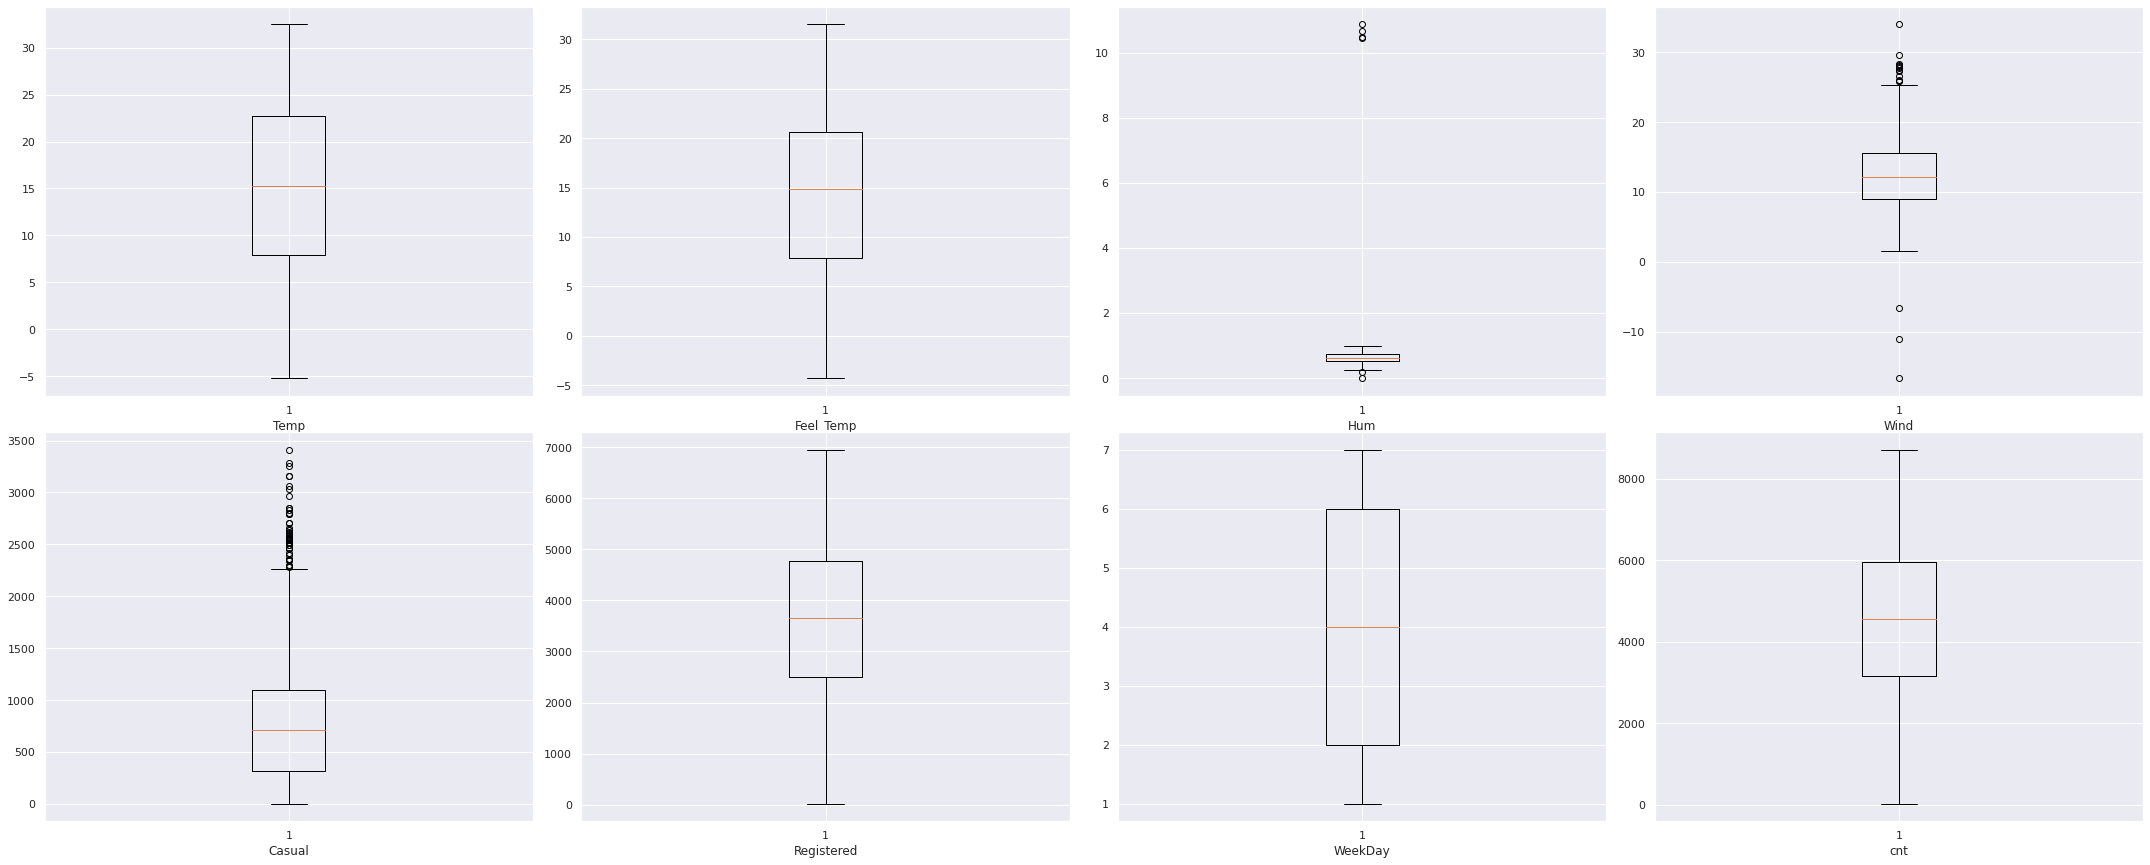

In [69]:
#sns.set(rc={'figure.figsize':(20,12)}) 
fix, axes = plt.subplots(2, 4)
plt.tight_layout()
for k in range(0, len(columnas_numericas)):
  plt.subplot(2, 4 , k + 1)
  #sns.boxplot(sub_df[sub_df.columns[k]])
  plt.boxplot(sub_df[sub_df.columns[k]])
  plt.xlabel(sub_df.columns[k])
plt.show()

De acuerdo al anterior gráfico, nos concentraremos en las primeras 4 variables:

*   Temp
*   Feel_Temp
*   Wind
*   Hum



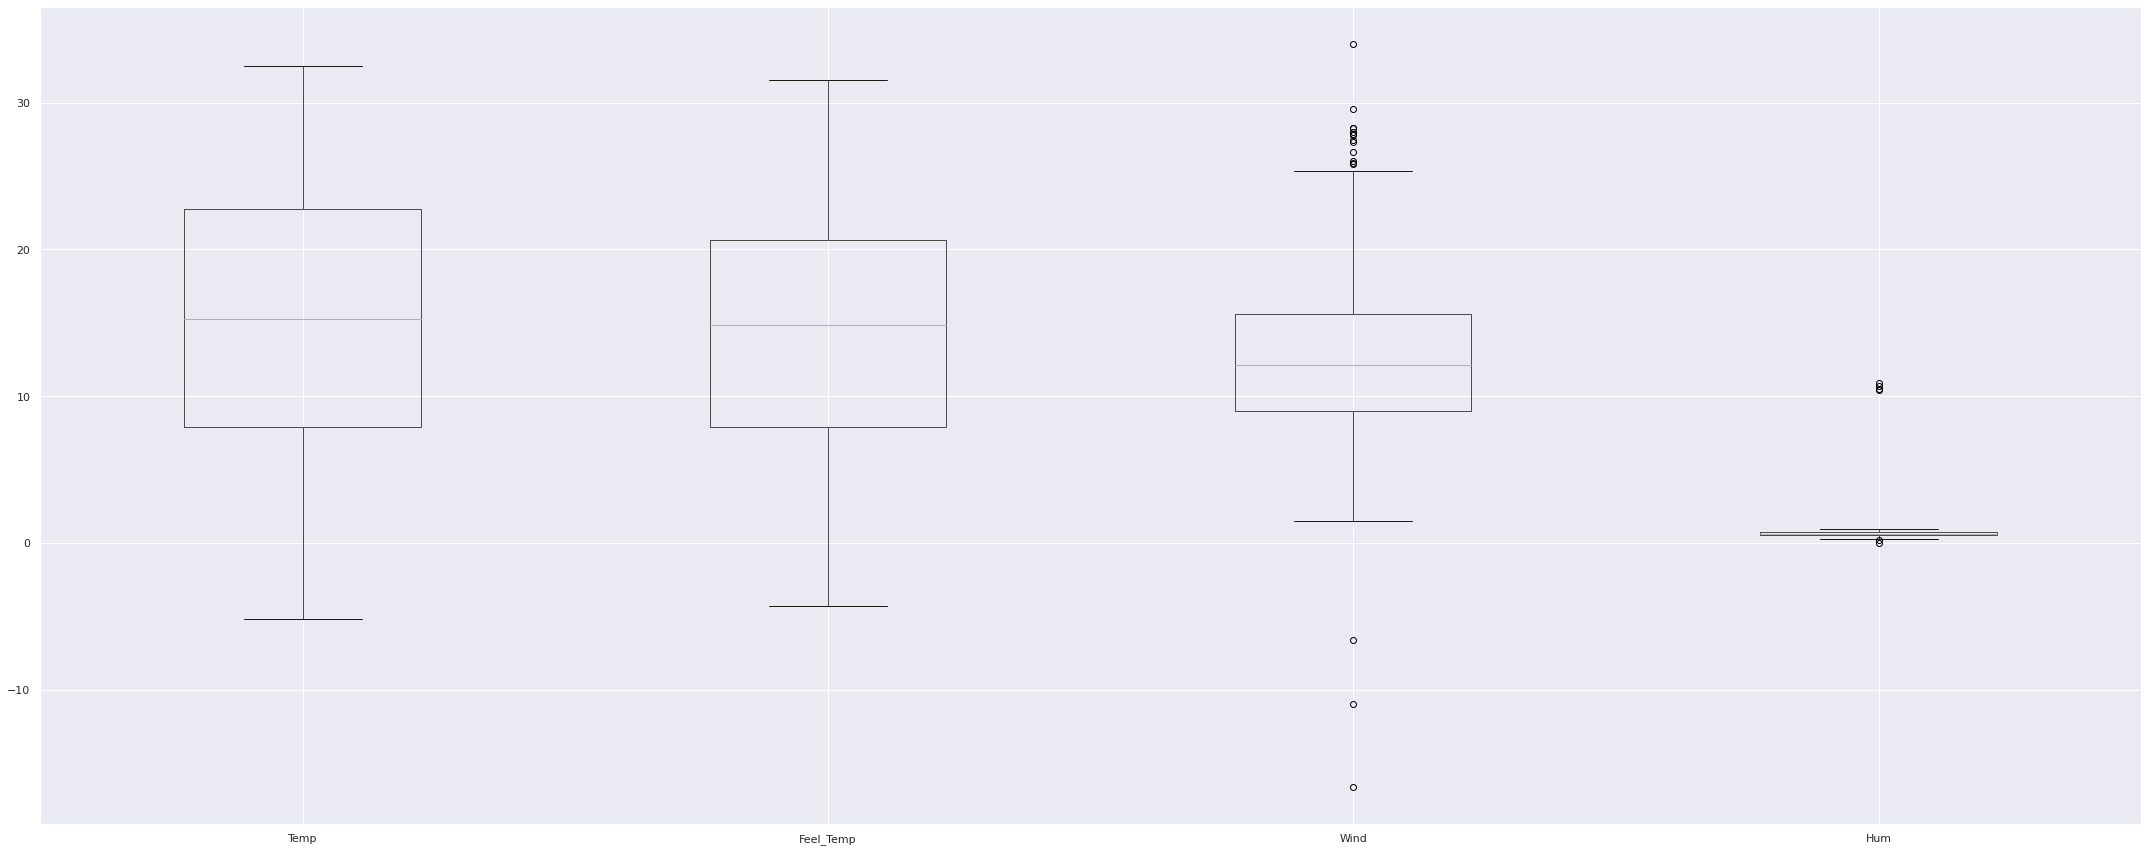

In [70]:
#sns.set(rc={'figure.figsize':(20,12)})
fix, axes = plt.subplots(1, 1)
datos.boxplot(column = ["Temp", "Feel_Temp", "Wind", "Hum"])
plt.tight_layout()

Finalmente revisamos los usuarios, pero analizaremos los casuales y registrados únicamente, dado que el conteo no es más que la suma de los 2 anteriores

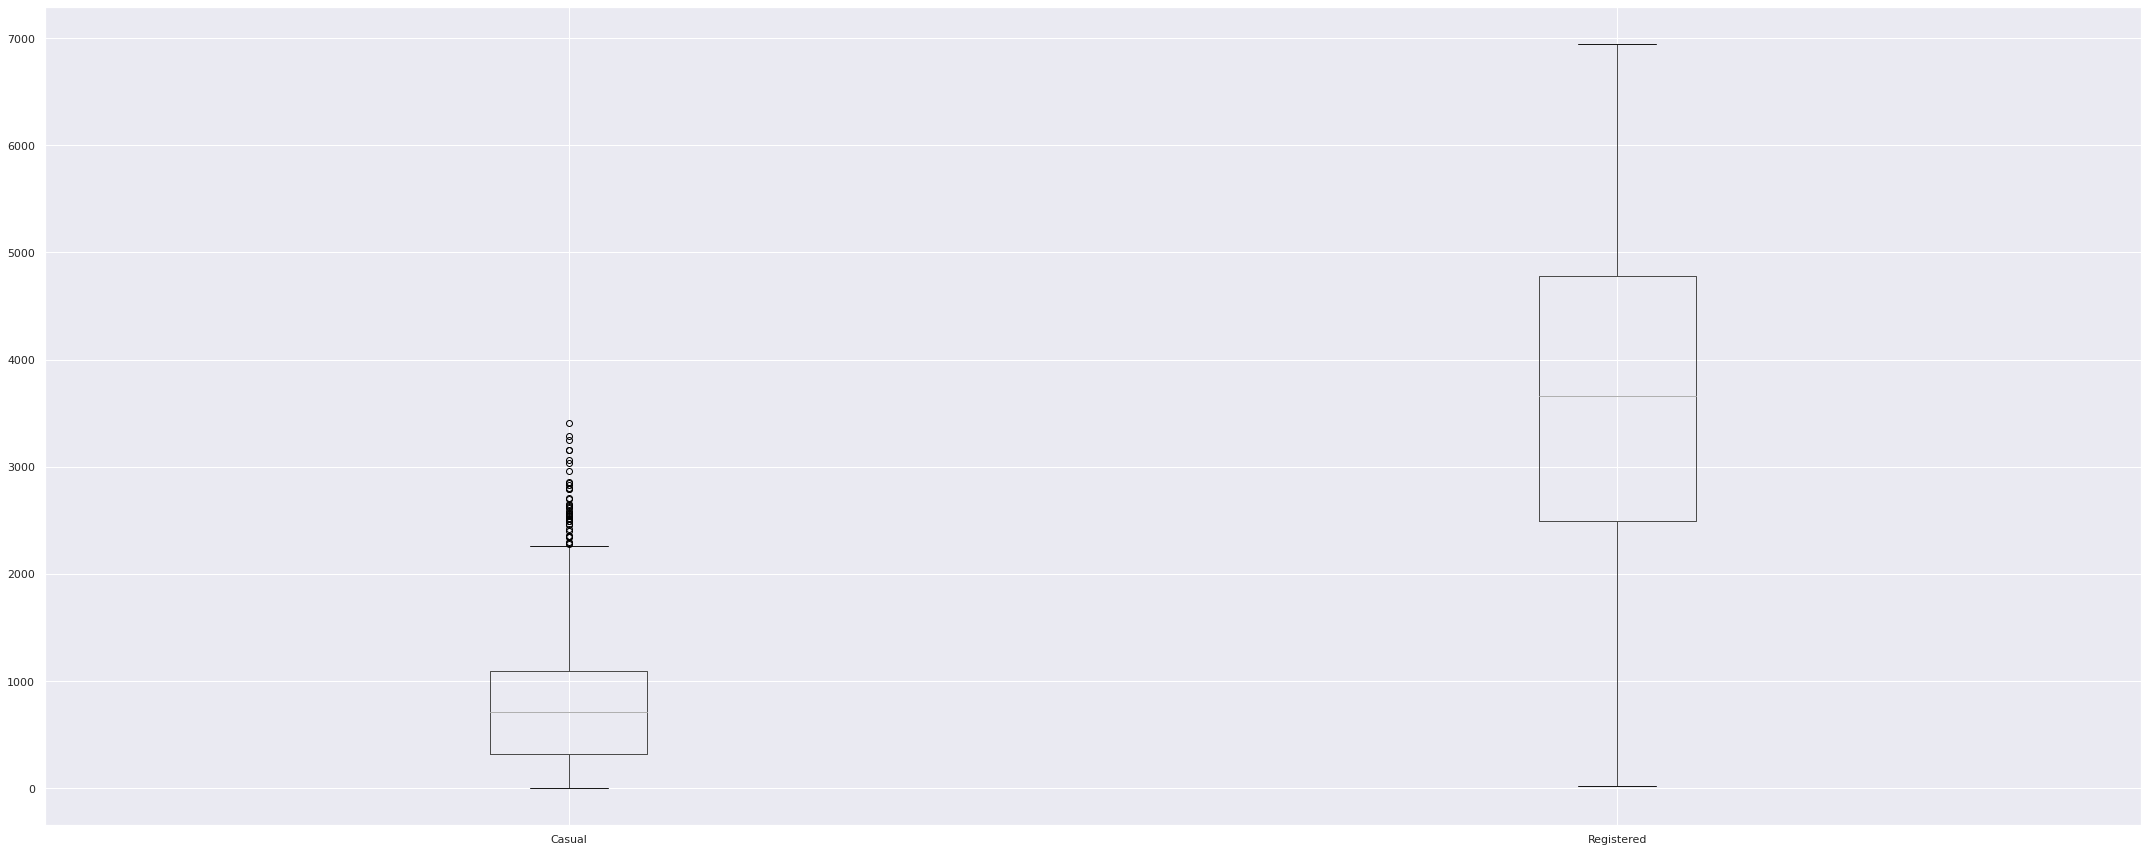

In [71]:
#sns.set(rc={'figure.figsize':(20,12)})
fix, axes = plt.subplots(1, 1)
datos.boxplot(column = ["Casual", "Registered"])
plt.tight_layout()

Verificando nuevamente la dispersión entre las variables

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


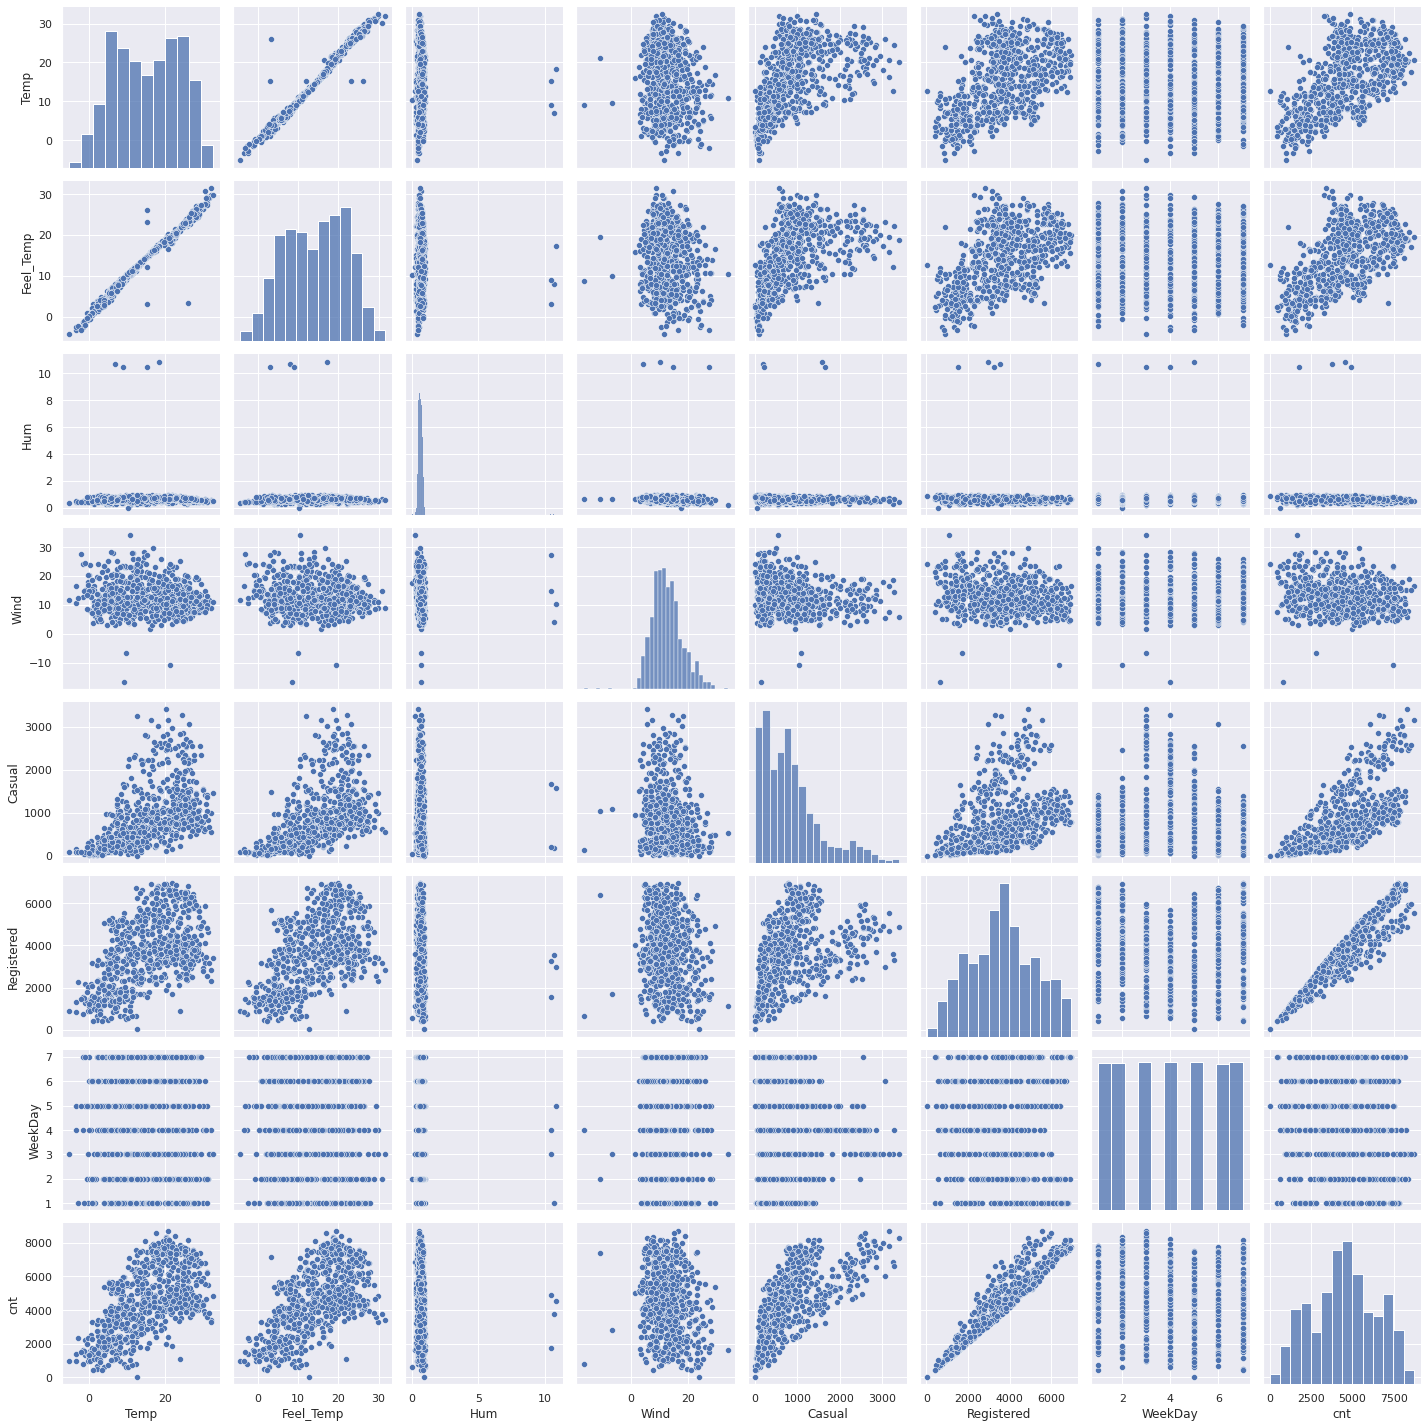

In [72]:
#sns.set(rc={'figure.figsize':(20, 12)}) 
sns.pairplot(datos[columnas_numericas], size=2.5)
plt.tight_layout()
plt.show()

3.2. Variables cualitativas

Reviso a continuación las 8 variables cuantitativas del modelo:

*   Season
*   Holiday
*   Weather
*   Weather group

In [73]:
columnas_cualitativas = ["Season", "Holiday", "Weather", "Weather Group"]

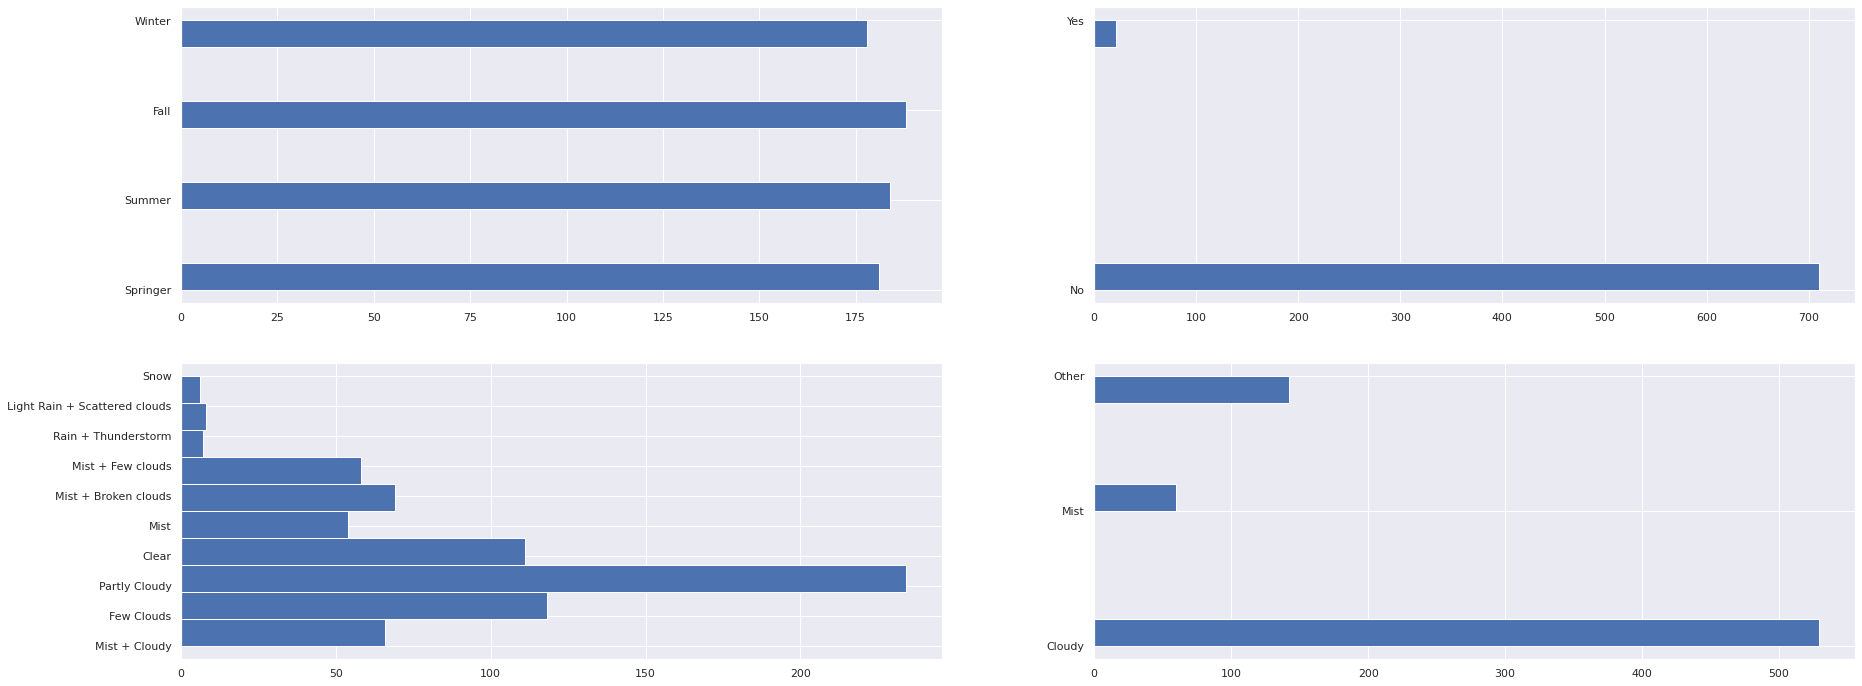

<Figure size 2160x864 with 0 Axes>

In [74]:
#sns.set(rc={'figure.figsize':(30,12)}) 
sub_df = datos[columnas_cualitativas]
fix, axes = plt.subplots(2, 2)
for k in range(0, len(columnas_cualitativas)):
  plt.subplot(2, 2 , k + 1)
  plt.hist(data=sub_df, x=sub_df.columns[k], orientation="horizontal")
plt.show()
plt.tight_layout()

Visualizo la matriz de correlación

In [75]:
corr = datos.corr()

<AxesSubplot:>

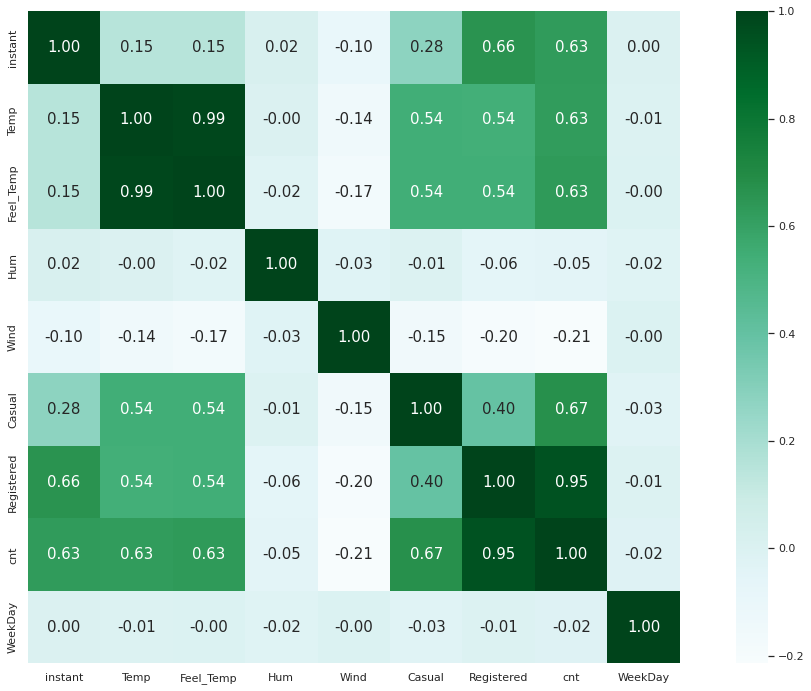

In [76]:
sns.set(rc={'figure.figsize':(20,12)}) 
sns.heatmap(corr, annot = True, square=True, fmt=".2f", annot_kws={'size': 15}, cmap="BuGn")

##4. Desarrollo de modelos

4.1. El escalamiento de variables

In [77]:
variables_lineal = ["Weather Group", "Temp", "Wind"]

In [78]:
scaler = StandardScaler()
reg_l = LinearRegression()
le_X = LabelEncoder()

In [79]:
datos['Weather Group'] = le_X.fit_transform(datos['Weather Group'])
datos['Holiday'] = le_X.fit_transform(datos['Holiday'])
datos['Season'] = le_X.fit_transform(datos['Season'])

4.2. Regresión lineal

In [80]:
datos_sel_df = datos.loc[datos['cnt'] <= datos['cnt'].quantile(.95)]

In [81]:
X = datos_sel_df[variables_lineal]

In [82]:
Y = datos_sel_df['cnt']

In [83]:
corr = datos_sel_df[variables_lineal + ['cnt']].corr()

<AxesSubplot:>

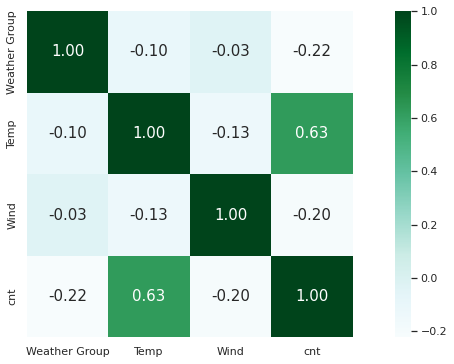

In [84]:
sns.set(rc={'figure.figsize':(15,6)}) 
sns.heatmap(corr, annot = True, square=True, fmt=".2f", annot_kws={'size': 15}, cmap="BuGn")

In [85]:
X_entrenar, X_probar, Y_entrenar, Y_probar = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [86]:
X_entrenar_esc = scaler.fit_transform(X_entrenar)
X_probar_esc = scaler.transform(X_probar)

In [87]:
reg_l.fit(X_entrenar, Y_entrenar)

LinearRegression()

In [88]:
reg_l.coef_

array([-351.99084497,  117.67707619,  -54.18283887])

In [89]:
reg_l.intercept_

3465.87650599829

In [90]:
Y_entrenar_pred = reg_l.predict(X_entrenar_esc)
Y_probar_pred = reg_l.predict(X_probar_esc)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


Text(0, 0.5, 'Predicción')

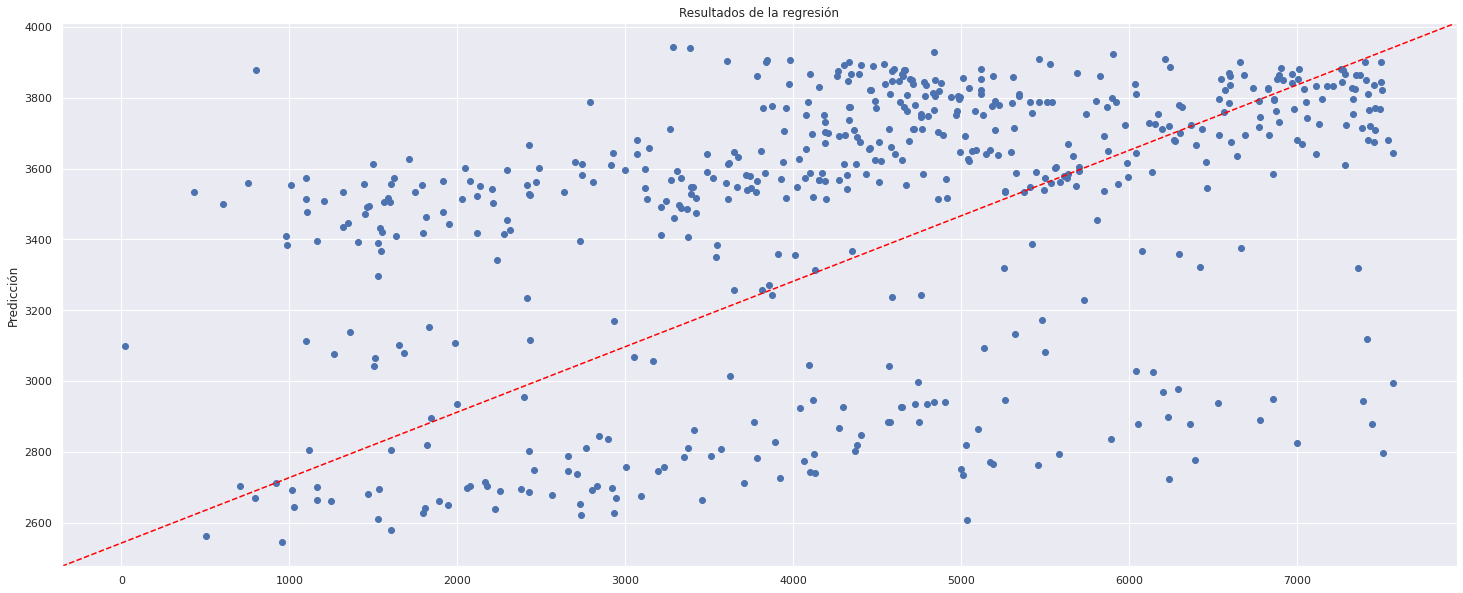

In [91]:
sns.set(rc={'figure.figsize':(20,4)}) 
fig, ax = plt.subplots(figsize=(25, 10))
#mae = median_absolute_error(Y_entrenar, Y_entrenar_pred)
mae = median_absolute_error(Y_entrenar, Y_entrenar_pred)
string_score = f"MAE de entrenamiento: {mae:.2f}"
mae = median_absolute_error(Y_probar_pred, Y_probar)
string_score += f"\nMAE de prueba: {mae:.2f}"

string_score = f"MAE: {mae:.2f} "
plt.scatter(Y_entrenar, Y_entrenar_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
#plt.text(3, 3, string_score)
plt.title("Resultados de la regresión")
plt.ylabel("Predicción")
#plt.xlabel("Total de calificaciones")

In [99]:
(r2_score(Y_entrenar, Y_entrenar_pred), r2_score(Y_probar, Y_probar_pred))

(-0.13513549129779756, 0.03926864658382789)

El valor de R2 es aceptable

##5. Evaluación de modelos

In [94]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [96]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, Y)
lin_reg.intercept_, lin_reg.coef_

(1401.9754210643232,
 array([-467.6862753 ,  351.58733689,   61.42122007,  279.58706486,
          -1.99140339,  -40.42447104,   -7.1295868 ,   -1.21252016,
          -2.75516574]))

In [98]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  "X does not have valid feature names, but"


ValueError: ignored

##6. Conclusiones